In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from multiprocessing import Pool

In [2]:
class UNetEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super(UNetEncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        ]
        if use_batchnorm:
            layers.insert(2, nn.BatchNorm2d(out_channels))
            layers.insert(5, nn.BatchNorm2d(out_channels))
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super(UNetDecoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        ]
        if use_batchnorm:
            layers.insert(2, nn.BatchNorm2d(out_channels))
            layers.insert(5, nn.BatchNorm2d(out_channels))
        self.block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.block(x)

class AttentionBlock(nn.Module):
    def __init__(self, in_channels, conditioning_dim):
        super(AttentionBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.fc = nn.Linear(conditioning_dim, in_channels)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, c):
        batch_size, channels, height, width = x.size()
        c = self.fc(c).view(batch_size, channels, 1, 1)
        attention_map = self.sigmoid(self.conv(x) + c)
        return x * attention_map


class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, conditioning_dim=6):
        super(ConditionalUNet, self).__init__()
        self.encoder1 = UNetEncoderBlock(in_channels, 64)
        self.encoder2 = UNetEncoderBlock(64, 128)
        self.encoder3 = UNetEncoderBlock(128, 256)
        
        self.bottleneck = UNetEncoderBlock(256, 512)
        
        self.decoder3 = UNetDecoderBlock(512 + 256, 256)
        self.decoder2 = UNetDecoderBlock(256 + 128, 128)
        self.decoder1 = UNetDecoderBlock(128 + 64, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.attention1 = AttentionBlock(64, conditioning_dim)
        self.attention2 = AttentionBlock(128, conditioning_dim)
        self.attention3 = AttentionBlock(256, conditioning_dim)
        self.attention_bottleneck = AttentionBlock(512, conditioning_dim)
    
    def forward(self, x, c):
        # Encoder
        enc1 = self.encoder1(x)
        enc1 = self.attention1(enc1, c)
        enc2 = self.encoder2(self.pool(enc1))
        enc2 = self.attention2(enc2, c)
        enc3 = self.encoder3(self.pool(enc2))
        enc3 = self.attention3(enc3, c)
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))
        bottleneck = self.attention_bottleneck(bottleneck, c)
        
        # Decoder
        dec3 = self.decoder3(torch.cat([F.interpolate(bottleneck, scale_factor=2, mode='bilinear', align_corners=False), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([F.interpolate(dec3, scale_factor=2, mode='bilinear', align_corners=False), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([F.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=False), enc1], dim=1))
        
        return self.final_conv(dec1)
    
def diffusion_step(x, t, betas):
    """
    Perform the diffusion step.
    
    Args:
        x (torch.Tensor): Input tensor (batch_size, channels, height, width).
        t (torch.Tensor): Timestep tensor.
        betas (torch.Tensor): Betas tensor.
    
    Returns:
        torch.Tensor: Noisy image.
        torch.Tensor: True noise added.
    """
    batch_size = x.size(0)
    noise = torch.randn_like(x)  # Sample noise
    alpha_t = (1 - betas).cumprod(dim=0)[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    noisy_x = x * alpha_t.sqrt() + noise * (1 - alpha_t).sqrt()


    return noisy_x, noise

def reverse_diffusion_step(x, c, t, model, betas):
    alpha_t = torch.cumprod(1 - betas, dim=0)[t]
    predicted_noise = model(x, c)
    return (x - (1 - alpha_t).sqrt() * predicted_noise) / alpha_t.sqrt()


In [3]:
from CASBI.utils.create_test_val_set import load_train_objs
train_set, val_set, test_set = load_train_objs('../../data/dataframe/dataframe.parquet', N_val=100, N_test=30, sets_path='./')

# train_set = train_set[train_set.columns.difference(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac', 'Galaxy_name'], sort=False)]
# val_set = val_set[train_set.columns.difference(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac', 'Galaxy_name'], sort=False)]
# val_set = torch.from_numpy(np.array(val_set.values, dtype=float))
# train_set = torch.from_numpy(np.array(train_set.values, dtype=float))

# Example transformation function
def preprocess_histogram(hist):
    hist = normalize_histogram(hist)
    # hist = rebin_histogram(hist, (64, 64))
    hist = log_transform_histogram(hist, epsilon=1e-6)
    return hist

# Example normalization, rebinning, and log transformation functions
def normalize_histogram(hist):
    min_val = np.min(hist)
    max_val = np.max(hist)
    return (hist - min_val) / (max_val - min_val + 1e-6)

def rebin_histogram(hist, new_bins):
    original_shape = hist.shape
    rebin_factor = (original_shape[0] // new_bins[0], original_shape[1] // new_bins[1])
    rebin_hist = hist.reshape(new_bins[0], rebin_factor[0], new_bins[1], rebin_factor[1]).sum(axis=(1, 3))
    return rebin_hist

def log_transform_histogram(hist, epsilon=1e-6):
    return np.log1p(hist + epsilon)

class HistogramDataset(Dataset):
    def __init__(self, histograms, conditionals, transform=preprocess_histogram):
        """
        Args:
            histograms (numpy array): Array of histograms.
            conditionals (numpy array): Array of conditional values.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.histograms = histograms
        self.conditionals = conditionals
        self.transform = transform

    def __len__(self):
        return len(self.histograms)

    def __getitem__(self, idx):
        histogram = self.histograms[idx]
        conditional = self.conditionals[idx]

        if self.transform:
            histogram = self.transform(histogram)

        # Convert numpy arrays to tensors
        histogram = torch.tensor(histogram, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        conditional = torch.tensor(conditional, dtype=torch.float32)
        
        return histogram, conditional




data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])


def process_galaxy(galaxy):
    histogram = np.histogram2d(
        train_set[train_set['Galaxy_name'] == galaxy]['feh'],
        train_set[train_set['Galaxy_name'] == galaxy]['ofe'],
        bins=64,
        range=[[min_feh, max_feh], [min_ofe, max_ofe]])[0]
    conditionals = train_set[train_set['Galaxy_name'] == galaxy].drop(
        ['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'],
        axis=1).values[0][2:-1]
    return histogram, conditionals

# Create a pool of workers
with Pool() as pool:
    # Map the function to the data
    results = pool.map(process_galaxy, train_set['Galaxy_name'].unique())

# Unpack the results
histograms, conditionals = zip(*results)

# Convert to numpy arrays
histograms = np.array(histograms).astype(np.float32)
conditionals = np.array(conditionals).astype(np.float32)
dataset = HistogramDataset(histograms, conditionals)


finish prepare data


In [4]:
# device='cuda:2'
# # Example training loop
# num_epochs = 100
# betas = torch.linspace(0.0001, 0.02, 10000).to(device)

# model = ConditionalUNet().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-5)
# criterion = nn.MSELoss()

# for epoch in tqdm(range(num_epochs)):
#     for histograms, conditionals in DataLoader(dataset, batch_size=1024, shuffle=True):
#         histograms, conditionals = histograms.to(device), conditionals.to(device)

#         optimizer.zero_grad()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

#         t = torch.randint(0, len(betas), (histograms.size(0),)).to(device)
#         noisy_histograms, true_noise = diffusion_step(histograms, t, betas)

#         predicted_noise = model(noisy_histograms, conditionals)
#         loss = criterion(predicted_noise, true_noise)

#         loss.backward()
#         optimizer.step()
#     if epoch % 10 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


In [5]:
device = 'cuda:2'
# torch.save(model.state_dict(), 'diffusion_model.pth')
model = ConditionalUNet().to(device)
model.load_state_dict(torch.load('diffusion_model.pth'))
betas = torch.linspace(0.0001, 0.02, 10_000).to(device)


In [6]:
def generate_histogram(c, model, T, betas):
    x = torch.randn((1, 1, 64, 64)).to(c.device)  # Start with random noise
    for t in reversed(range(T)):
        x = reverse_diffusion_step(x, c, t, model, betas)
    return x


def sample_val(N=1):
    galaxy_name = val_set['Galaxy_name'].sample(N)
    histogram = np.histogram2d(val_set[val_set['Galaxy_name'].isin(galaxy_name)].values[:, 0], val_set[val_set['Galaxy_name'].isin(galaxy_name)].values[:, 1],
                               bins=64,
                               range=[[min_feh, max_feh], [min_ofe, max_ofe]])[0]   
    histogram = preprocess_histogram(histogram)                             
    conditionals = val_set[val_set['Galaxy_name'].isin(galaxy_name)].drop(['Galaxy_name', 'a', 'redshift', 'mean_FeMassFrac', 'mean_OMassFrac', 'std_FeMassFrac','std_OMassFrac'], axis=1).values[0, 2:]
    return histogram, conditionals

true_hist, conditional = sample_val()
c = torch.from_numpy(conditional).float().to(device)
generated_histogram = generate_histogram(c, model, T=10_000, betas=betas)

/export/home/vgiusepp/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU  has a total capacity of 39.39 GiB of which 126.38 MiB is free. Including non-PyTorch memory, this process has 39.26 GiB memory in use. Of the allocated memory 38.75 GiB is allocated by PyTorch, and 9.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Exception raised from malloc at ../c10/cuda/CUDACachingAllocator.cpp:1143 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7f659437a897 in /export/home/vgiusepp/.local/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x35abf (0x7f6594

KeyboardInterrupt: 

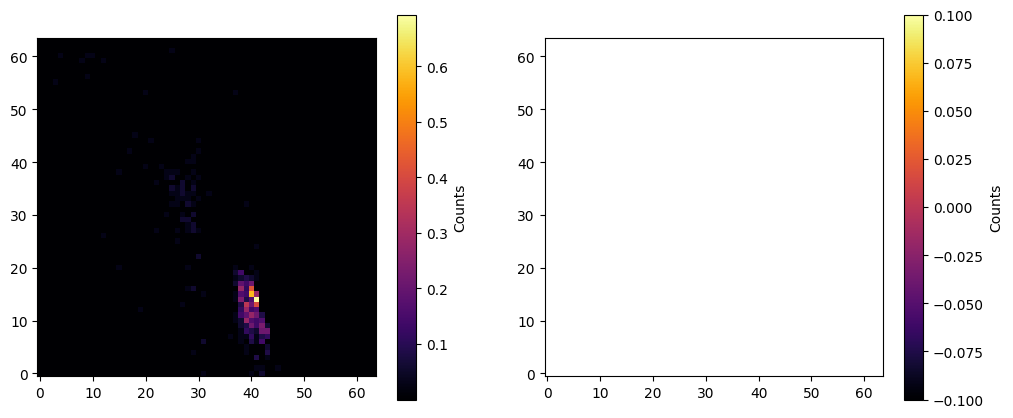

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax =  fig.add_subplot(121)
im = ax.imshow(true_hist.T, cmap='inferno', origin='lower')
cbar = fig.colorbar(im, ax=ax, label='Counts')

ax = fig.add_subplot(122)
im = ax.imshow(generated_histogram.squeeze().detach().cpu().numpy().T, cmap='inferno', origin='lower')
cbar = fig.colorbar(im, ax=ax, label='Counts')
